# The Markov Decision Process & Obtaining an Optimal Policy

The following notebook aims to be a closing exercise for the Markov Decision Process of the Introduction to Reinforcement Learning Course.
We will be solving the <span style="color: #1E90FF;">Frozen Lake Problem</span>. In it we will be framing it as  Markov Decision Process (MDP) and obtaining the optimal policy for it using value and policy iteration.

## **1. The Frozen Lake Problem**

This is a toy problem available in the [Gymnasium](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) reinforcement learning library.

The objective of the problem is to cross a frozen lake from a starting position to a goal without falling into any of the holes by walking over the lake. There is also a possibility for the player character to not move in the desired location due to the slippery nature of the lake.

<div align="center">
  <img src="images/FrozenLakeExample.png" alt="Frozen Lake" width="400">
</div>


Our player always starts at position [0,0] of the frozen lake with the goal located at the far extent of the world [3,3]. There are ice holes distributed around the map with there always being a path to the goal. The player will be making moves until they reach the goal or  hole.

The lake is slippery so the player may move perpendicular to the intended direction sometimes.

### **1.1. Action & Observation Spaces**

The **action space** is (1,) in the range {0,3}, indicating which direction the player will move in.

* 0: Move Left
* 1: Move Down
* 2: Move Right
* 3: Move Up

Its **observation space** is a value representing the player's current position as current_row * ncols + current_col (where both row and col start at 0). Therefore the observation is returned as an integer.

### **1.2 Rewards**

Default reward schedule:
* Reach goal: +1
* Reach hole: 0
* Reach frozen: 0

### **1.3 Episode's End**

The episode ends if the following happens:
* Termination:
    1. The player moves into a hole.
    2. The player reaches the goal at max(nrow) * max(ncol) - 1 (location [max(nrow)-1, max(ncol)-1])
* Truncation:
    1. The length of the episode is 100 for FrozenLake 4x4

### **1.4 Information**
step() and reset() return a dict with the following keys:
* p: transition probability for the state which will be impacted by the is_slippery parameter.

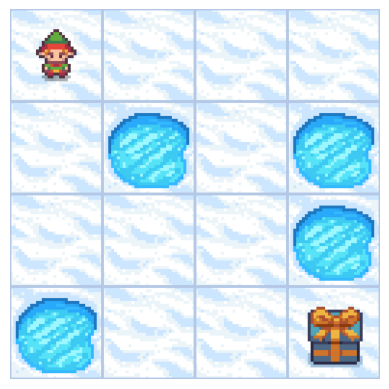

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import time

# ✅ Must include render_mode="rgb_array" to get image frames
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array", disable_env_checker=True)

# Reset environment
obs, info = env.reset()

for _ in range(1):
    frame = env.render()              # Get RGB frame
    plt.imshow(frame)
    plt.axis("off")
    display.display(plt.gcf())        # Show current frame
    display.clear_output(wait=True)
    time.sleep(0.3)                   # Control frame rate

    # Take random actions
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()

env.close()

## **2. Finding the Optimal Value Function**

In order to achieve the optimal value function we can use value iteration.

In [ ]:
def value_iteration(env, gamma=1.0, max_iterations=1_000, threshold=1e-20):
    """
    Performs value iteration for a discrete Gymnasium environment.
    Returns the optimal value function.
    """
    # Check environment type
    assert hasattr(env, "P"), "This function only works for environments with a 'P' attribute (e.g., FrozenLake, Taxi)."

    # Initialize value table
    value_table = np.zeros(env.observation_space.n)

    for i in range(max_iterations):
        updated_value_table = np.copy(value_table)

        for state in range(env.observation_space.n):
            Q_values = []
            for action in range(env.action_space.n):
                q_sa = 0
                for prob, next_state, reward, terminated in env.P[state][action]:
                    q_sa += prob * (reward + gamma * (0 if terminated else updated_value_table[next_state]))
                Q_values.append(q_sa)
            value_table[state] = max(Q_values)

        # Convergence check
        if np.sum(np.abs(updated_value_table - value_table)) <= threshold:
            print(f"Value iteration converged at iteration #{i+1}.")
            break

    return value_table


def extract_policy(env, value_table, gamma=1.0):
    """
    Extracts the optimal policy given the optimal value function.
    """
    assert hasattr(env, "P"), "This function only works for environments with a 'P' attribute (e.g., FrozenLake, Taxi)."

    policy = np.zeros(env.observation_space.n, dtype=int)

    for state in range(env.observation_space.n):
        Q_values = np.zeros(env.action_space.n)

        for action in range(env.action_space.n):
            for prob, next_state, reward, terminated in env.P[state][action]:
                Q_values[action] += prob * (reward + gamma * (0 if terminated else value_table[next_state]))

        policy[state] = np.argmax(Q_values)

    return policy


In [ ]:
env_unwrapped = env.unwrapped  # 🔑 this gives you direct access to .P
optimal_value_function = value_iteration(env=env_unwrapped, gamma=1.0)

In [ ]:
optimal_policy = extract_policy(env.unwrapped, optimal_value_function)

In [ ]:
print(optimal_policy)

[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]


## **2. Finding the Optimal Policy**

In [ ]:
def compute_value_function(env, policy, gamma=1.0, threshold=1e-10):
    """
    Evaluate a given policy by iteratively updating the value function.
    """
    value_table = np.zeros(env.observation_space.n)

    while True:
        updated_value_table = np.copy(value_table)

        for state in range(env.observation_space.n):
            action = int(policy[state])
            value_table[state] = sum([
                trans_prob * (reward + gamma * (0 if done else updated_value_table[next_state]))
                for trans_prob, next_state, reward, done in env.P[state][action]
            ])

        if np.sum(np.abs(updated_value_table - value_table)) <= threshold:
            break

    return value_table


def extract_policy(env, value_table, gamma=1.0):
    """
    Improve the policy greedily based on the current value function.
    """
    policy = np.zeros(env.observation_space.n, dtype=int)

    for state in range(env.observation_space.n):
        Q_table = np.zeros(env.action_space.n)
        for action in range(env.action_space.n):
            for trans_prob, next_state, reward, done in env.P[state][action]:
                Q_table[action] += trans_prob * (reward + gamma * (0 if done else value_table[next_state]))
        policy[state] = np.argmax(Q_table)

    return policy


def policy_iteration(env, gamma=1.0, max_iterations=1_000):
    """
    Run Policy Iteration: alternate between policy evaluation and improvement
    until convergence.
    """
    old_policy = np.zeros(env.observation_space.n, dtype=int)

    for i in range(max_iterations):
        # Policy evaluation
        value_function = compute_value_function(env, old_policy, gamma)

        # Policy improvement
        new_policy = extract_policy(env, value_function, gamma)

        if np.all(old_policy == new_policy):
            print(f"✅ Policy Iteration converged at iteration #{i+1}")
            break

        old_policy = new_policy

    return new_policy, value_function

In [ ]:
import gymnasium as gym

# Create and unwrap the environment
env = gym.make("FrozenLake-v1", is_slippery=True, disable_env_checker=True)
env = env.unwrapped

# Run policy iteration
optimal_policy, optimal_value = policy_iteration(env, gamma=0.99)

print("Optimal Policy:\n", optimal_policy.reshape(4,4))
print("Optimal Value Function:\n", optimal_value.reshape(4,4))

✅ Policy Iteration converged at iteration #7
Optimal Policy:
 [[0 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]
Optimal Value Function:
 [[0.54202593 0.49880319 0.47069569 0.4568517 ]
 [0.55845096 0.         0.35834807 0.        ]
 [0.59179874 0.64307982 0.61520756 0.        ]
 [0.         0.74172044 0.86283743 0.        ]]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_policy(env, policy, title="Optimal Policy with Map Colors"):
    actions = ['←', '↓', '→', '↑']  # Mapping: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP
    grid_size = int(np.sqrt(env.observation_space.n))

    # Create the color map
    color_map = {
        b'S': '#ADD8E6',  # Start - light blue
        b'F': '#FFFFFF',  # Frozen (safe) - white
        b'H': '#808080',  # Hole - gray
        b'G': '#90EE90',  # Goal - light green
    }

    fig, ax = plt.subplots(figsize=(4,4))
    ax.set_xlim(-0.5, grid_size - 0.5)
    ax.set_ylim(-0.5, grid_size - 0.5)
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.invert_yaxis()
    ax.set_title(title)
    plt.grid(True)

    # Draw background tiles
    for s in range(env.observation_space.n):
        row, col = divmod(s, grid_size)
        tile = env.desc[row][col]
        ax.add_patch(plt.Rectangle((col-0.5, row-0.5), 1, 1, color=color_map[tile], ec='black'))

    # Draw arrows and labels
    for s in range(env.observation_space.n):
        row, col = divmod(s, grid_size)
        tile = env.desc[row][col]

        if tile == b'H':
            text = 'H'
        elif tile == b'G':
            text = 'G'
        elif tile == b'S':
            text = 'S'
        else:
            text = actions[policy[s]]

        ax.text(col, row, text, ha='center', va='center', fontsize=16, fontweight='bold')

    plt.show()


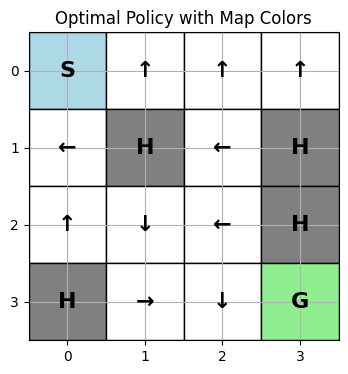

In [ ]:
plot_policy(env, optimal_policy)

## 3. Simulating the Policy

In [ ]:
import time
from IPython import display
import matplotlib.pyplot as plt

def simulate_policy(env, policy, episodes=3, delay=0.1):
    """
    Simulate the learned policy on FrozenLake and visualize the agent's path.
    Works inside Jupyter notebooks.
    """
    for ep in range(episodes):
        obs, info = env.reset()
        done = False
        step = 0
        total_reward = 0

        print(f"Episode {ep+1}")
        while not done:
            # Render the current frame as RGB
            frame = env.render()
            plt.imshow(frame)
            plt.axis("off")
            plt.title(f"Episode {ep+1} | Step {step} | State {obs} | Action {policy[obs]}")
            display.display(plt.gcf())
            display.clear_output(wait=True)

            # Take the action from the policy
            action = policy[obs]
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            step += 1

            done = terminated or truncated
            time.sleep(delay)

        # Show final frame
        frame = env.render()
        plt.imshow(frame)
        plt.axis("off")
        plt.title(f"Episode {ep+1} finished! Total reward: {total_reward}")
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)

    print("Simulation complete.")
    env.close()


Simulation complete.


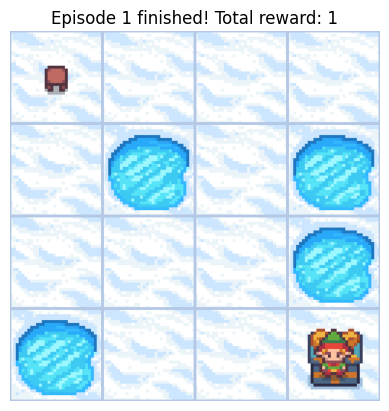

In [ ]:
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array", disable_env_checker=True)
env = env.unwrapped  # allows access to .P for your algorithms

# Run the learned policy
simulate_policy(env, optimal_policy, episodes=1, delay=0.6)